In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install mne
%matplotlib inline

     |████████████████████████████████| 6.8MB 4.8MB/s 


In [3]:
import os
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sn

import mne
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)
from mne.decoding import UnsupervisedSpatialFilter
from mne.baseline import rescale
from mne.stats import bootstrap_confidence_interval
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

import matplotlib.pyplot as plt

from ipywidgets import interact

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

from sklearn.externals import joblib

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import sys
sys.path.append('/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/NL_PCA')
from nlpca import nlpca

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
# Matriz de confusion
def plot_matriz_confusion(y_test, y_predict, labels, save=None, name_fig='fig_1.svg', file_directory='', titulo='Matriz de confusión', figsize = (7,5)):
  
    cm = confusion_matrix(y_test, y_predict)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100

    annot = np.empty_like(cm).astype(np.dtype('U30'))
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d\n' % (p, c, s)
            else:
                annot[i, j] = '%.2f%%\n%d/%d\n' % (p, c, s)
              
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Estimados'
    cm.columns.name = 'Verdaderos'

    fig = plt.figure(figsize = figsize)
    fig.patch.set_facecolor('White')
    ax = fig.add_subplot(1,1,1)

    ax.set_title(titulo,fontdict={'weight': 'normal','size':20})
    ax.axhline(y=0, color='Black',linewidth=0.2)
    ax.axhline(y=2, color='Black',linewidth=0.2)
    ax.axvline(x=0, color='Black',linewidth=0.2)
    ax.axvline(x=2, color='Black',linewidth=0.2)

    sn.set(font_scale=1.2)  
    sn.heatmap(cm, cmap= "Blues", annot=annot, fmt='', linecolor='Black',linewidths=.1, cbar=None)

    if save==True:
        sns_plot = sn.heatmap(cm, cmap= "Blues", annot=annot, fmt='', linecolor='Black',linewidths=.1, cbar=None)
        fig = sns_plot.get_figure()
        fig.savefig(file_directory+name_fig)
        
# Matriz de confusion con rechazo
def plot_matriz_confusion_rechazo(y_test, y_predict, labels, save=None, name_fig='fig_1.svg', file_directory='', titulo='Matriz de confusión'):
  
    cm = confusion_matrix(y_test, y_predict)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if np.isnan(cm_perc[i][j]):
                cm_perc[i][j]=0
                

    annot = np.empty_like(cm).astype(np.dtype('U30'))
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            else:
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
              
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Estimados'
    cm.columns.name = 'Verdaderos'

    fig = plt.figure(figsize = (7,5))
    fig.patch.set_facecolor('White')
    ax = fig.add_subplot(1,1,1)

    ax.set_title(titulo,fontdict={'weight': 'normal','size':20})
    ax.axhline(y=0, color='Black',linewidth=0.2)
    ax.axhline(y=2, color='Black',linewidth=0.2)
    ax.axhline(y=3, color='Black',linewidth=0.2)
    ax.axvline(x=0, color='Black',linewidth=0.2)
    ax.axvline(x=2, color='Black',linewidth=0.2)
    ax.axvline(x=3, color='Black',linewidth=0.2)

    sn.set(font_scale=1.2)  
    sn.heatmap(cm, cmap= "Blues", annot=annot, fmt='', linecolor='Black',linewidths=.1, cbar=None)

    if save==True:
        sns_plot = sn.heatmap(cm, cmap= "Blues", annot=annot, fmt='', linecolor='Black',linewidths=.1, cbar=None)
        fig = sns_plot.get_figure()
        fig.savefig(file_directory+name_fig)
        
# Seleccion del folder actual
currentFolder = os.getcwd()

In [5]:
# Multichannel Data Visualization
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

def roundNearestTen( n ): 
  
    # Smaller multiple 
    a = (n // 10) * 10
      
    # Larger multiple 
    b = a + 10
      
    # Return of closest of two 
    return (b if n - a > b - n else a) 

def paletteColorPlotlyAlpha (alphaColor=1.0):
    plotlyColors=['rgba(31, 119, 180, '+str(alphaColor)+')', 'rgba(255, 127, 14, '+str(alphaColor)+')',
                  'rgba(44, 160, 44, '+str(alphaColor)+')', 'rgba(214, 39, 40, '+str(alphaColor)+')',
                  'rgba(148, 103, 189, '+str(alphaColor)+')', 'rgba(140, 86, 75, '+str(alphaColor)+')',
                  'rgba(227, 119, 194, '+str(alphaColor)+')', 'rgba(127, 127, 127, '+str(alphaColor)+')',
                  'rgba(188, 189, 34, '+str(alphaColor)+')', 'rgba(23, 190, 207, '+str(alphaColor)+')']
    return plotlyColors

def plotMultiChannelSignal(df, events, sfreq, init, end, title, ylabel, xlabel):
    #print(len(events))
    
    ## Validating init and end
    if init < 0 or init > len(df):
        print('init should be between ['+str(0)+', '+str(len(df))+']')
    if end < 0 or end > len(df):
        print('end should be between ['+str(0)+', '+str(len(df))+']')
        
    Events = events[init:end+1]
    
    timeLine = [val/sfreq for val in range(len(df))]
    timeLine = timeLine[init:end+11]
    
    ## Filtering positions
    dfFiltered = df.iloc[init:end+1]   
    #dfFiltered = dfFiltered[dfFiltered.columns.tolist()[:4]]
    
    ## Getting Symetric closest ten power Ymin, Ymax
    minVal = min([dfFiltered[col].min() for col in dfFiltered.columns.tolist()])
    maxVal = max([dfFiltered[col].max() for col in dfFiltered.columns.tolist()])
    if abs(minVal) > abs(maxVal):
        minVal = -roundNearestTen(abs(minVal))
        maxVal = +roundNearestTen(abs(minVal))
    else:
        minVal = -roundNearestTen(abs(maxVal))
        maxVal = +roundNearestTen(abs(maxVal))
    
    ## Color Palette 
    colorsLine = paletteColorPlotlyAlpha (alphaColor=1.0)
    colorsRect = paletteColorPlotlyAlpha (alphaColor=0.1)
    
    ## Creating array of Scatter data
    data = []
    shapes = []
    annotations = []
    count = len(dfFiltered.columns.tolist())-1
    for col in dfFiltered.columns.tolist():
        x = timeLine
        y = dfFiltered[col].values.tolist()
        yLabels = [col+': '+"{:.3f}".format(val) for val in y]
        y = [(val+((count)*2*maxVal)) for val in y]
        
        trace = go.Scatter(
                        x = x,
                        y = y,
                        text = yLabels,
                        hoverinfo = 'text',
                        name = col,
                        line = dict(
                        color = colorsLine[count % len(colorsLine)],
                        width = 4,)
        )
        data.append(trace)
        
        
        ## Building shapes
        
        if count==len(dfFiltered.columns.tolist())-1:
            minY = minVal
            maxY = maxVal
        else:
            minY = minY + 2*maxVal
            maxY = maxY + 2*maxVal
        
        x0 = x[0]
        x1 = x[-1]
        
        shapes.append(dict(
                            type = 'rect',
                            layer='below',
                            name = col,
                            x0 = x0,
                            y0 = minY,
                            x1 = x1,
                            y1 = maxY,
                            line = dict(
                                    color = colorsRect[count % len(colorsRect)],
                                    width = 1,
                            ),
                            fillcolor = colorsRect[count % len(colorsRect)]
                      )
        )
        
        count -= 1
    
    eventsSet = list(set(Events))
    for i in range(len(Events)):
        if Events[i] != -2:
            #print(str(len(Events))+' - '+ str(i))
            #print(len(timeLine))
            x0 = timeLine[i]
            x1 = timeLine[i+10]
            y0 = minVal
            y1 = y0+(len(dfFiltered.columns.tolist())*2*maxVal)
            indices = [k for k, x in enumerate(eventsSet) if x == Events[i]]
            eventIndex = indices[0]
            shapes.append(dict(
                            type = 'rect',
                            layer='below',
                            name = str(Events[i]),
                            x0 = x0,
                            y0 = y0,
                            x1 = x1,
                            y1 = y1,
                            line = dict(
                                    color = colorsLine[eventIndex % len(colorsLine)],
                                    width = 1,
                            ),
                            fillcolor = colorsLine[eventIndex % len(colorsLine)]
                      )
            )
            annotations.append(dict(
                                x=x0,
                                y=y1,
                                xref='x',
                                yref='y',
                                text=Events[i],
                                font=dict(
                                    size=14,
                                    color=colorsLine[eventIndex % len(colorsLine)]
                                ),
                                showarrow=True,
                                arrowhead=7,
                                ax=0,
                                ay=-20
                        )
            )
            
        
        
    # Edit the layout
    layout = dict(
                  shapes=shapes,
                  annotations = annotations,
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  title = title,
                  xaxis = dict(
                               title = xlabel,
                               showticklabels=True
                  ),
                  yaxis = dict(
                               title = ylabel,
                               showticklabels=False
                  ),
              )

    fig = dict(data=data, layout=layout)
    iplot(fig, filename='MultichannelPlot')

In [6]:
# Return X and y data from Epoched Dataframe
# X: EEG data, in format Ntrials x Nchannels X Nsamples
# y: labels
def getEEGXY(df, channels, columnClass, ColumnEpoch):
  import numpy as np
  classes = df[columnClass].unique()
  X = []
  y = []
  z = df[columnClass].values.tolist()
  for label in classes:
    dfClass = df[df[columnClass]==label]
    epochs = dfClass[ColumnEpoch].unique()
    for epoch in epochs:
      dfEpoch = dfClass[dfClass[ColumnEpoch]==epoch]
      y.append(label)
      X.append(np.transpose(dfEpoch[channels].values))
  return np.stack(X,axis=0), np.array(y), np.array(z).reshape(len(np.stack(X,axis=0)[:,0,0]),len(np.stack(X,axis=0)[0,0,:]))

In [7]:
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)

In [8]:
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
trainDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage/RawData/'
subject = '01'
sesion = '01'
task = 'per'
# task = 'img'
path_raw_file = baseDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
path_raw_train = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
filename = 'PERIMG01_0002.vhdr'
filename_sub = 'PERIMG01_sub0002.vmrk'
data_raw_file = path_raw_file  + filename
data_raw_file

'/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/subj01/ses01/per/PERIMG01_0002.vhdr'

In [9]:
eeg_raw = mne.io.read_raw_brainvision(data_raw_file)
print(eeg_raw)
print(eeg_raw.info)

Extracting parameters from /content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/subj01/ses01/per/PERIMG01_0002.vhdr...
Setting channel info structure...
<RawBrainVision | PERIMG01_sub0002.eeg, 63 x 684960 (685.0 s), ~172 kB, data not loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 63 items (63 EEG)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2018-04-08 10:58:54 UTC
 nchan: 63
 projs: []
 sfreq: 1000.0 Hz
>


In [10]:
channels = eeg_raw.info['ch_names']
Fs = eeg_raw.info['sfreq']

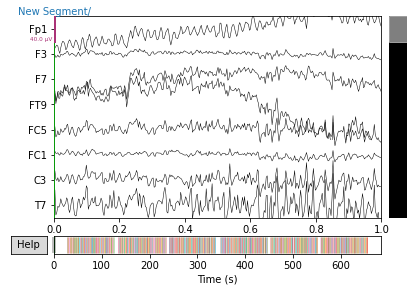

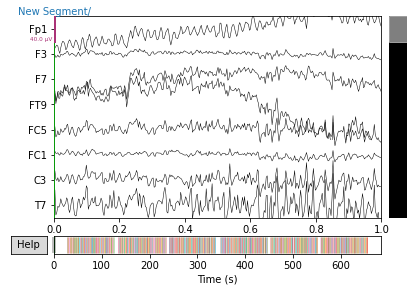

In [11]:
eeg_raw.plot(duration=1, n_channels=8)

In [12]:
print(eeg_raw.annotations)
print(str(len(eeg_raw.annotations))+' Eventos en el archivo')
print('Cada uno de '+str(set(eeg_raw.annotations.duration))+ ' segundos de duración')
print('Tipo de Eventos: ' + str(set(eeg_raw.annotations.description)))
print('El primer evento ocurrió aproximadamente ' + str(eeg_raw.annotations.onset[0]) + ' segundo(s) después de que comenzó la grabación')

<Annotations | 601 segments: New Segment/ (1), Stimulus/S 11 (40), ...>
601 Eventos en el archivo
Cada uno de {0.001} segundos de duración
Tipo de Eventos: {'Stimulus/S 33', 'Stimulus/S 31', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S 42', 'Stimulus/S 12', 'Stimulus/S 22', 'Stimulus/S 21', 'Stimulus/S 23', 'Stimulus/S 41', 'Stimulus/S 88', 'New Segment/', 'Stimulus/S 43', 'Stimulus/S 32'}
El primer evento ocurrió aproximadamente 0.0 segundo(s) después de que comenzó la grabación


In [13]:
events, event_dict = mne.events_from_annotations(eeg_raw)
print(event_dict)
print(events[:5])

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 43', 'Stimulus/S 88']
{'New Segment/': 99999, 'Stimulus/S 11': 11, 'Stimulus/S 12': 12, 'Stimulus/S 13': 13, 'Stimulus/S 21': 21, 'Stimulus/S 22': 22, 'Stimulus/S 23': 23, 'Stimulus/S 31': 31, 'Stimulus/S 32': 32, 'Stimulus/S 33': 33, 'Stimulus/S 41': 41, 'Stimulus/S 42': 42, 'Stimulus/S 43': 43, 'Stimulus/S 88': 88}
[[    0     0 99999]
 [26682     0    41]
 [27716     0    11]
 [28649     0    32]
 [29701     0    88]]


In [14]:
#Reemplazar por nombres de los objetos
#event_dict = {'New Segment/': 99999, 'Apple': 11, 'Carrot': 12, 'Pink': 13, 'Butterfly': 21, 'Chicken': 22, 'Sheep': 23, 'Car': 31, 'Chair': 32, 'Violin': 33,'Ear': 41,'Eye': 42,'Hand': 43,'Rest': 88}
event_dict= {'New Segment/': 99999, 'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43, 'Descanso': 88}

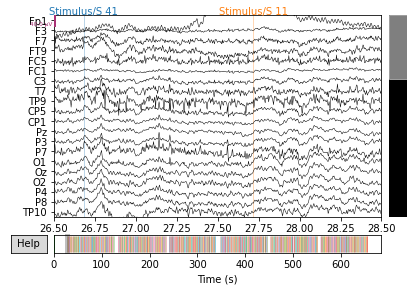

In [15]:
fig = eeg_raw.plot(start=26.5, duration=2)

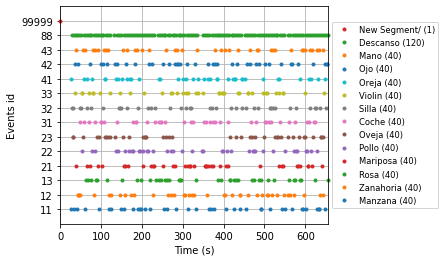

In [16]:
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=eeg_raw.info['sfreq'],
                          first_samp=eeg_raw.first_samp)

In [17]:
#Events = events[:,2]
#print(Events)
reject_criteria = dict(eeg=100e-6)       # 100 µV
tmin, tmax = (-0.5, 0.8)  # epoch from 100 ms before event to 600 ms after it
baseline = (None, 0)      # baseline period from start of epoch to time=0
epochs = mne.Epochs(eeg_raw, events, event_dict, tmin, tmax, proj=True,
                    baseline=baseline, preload=True).resample(250)# Resample of 1000 Hz to 250Hz
print('New sampling rate:', epochs.info['sfreq'], 'Hz')
#del eeg_raw

Not setting metadata
Not setting metadata
601 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 601 events and 1301 original time points ...
1 bad epochs dropped
New sampling rate: 250.0 Hz


In [18]:
df = epochs.to_data_frame()
event = [] 
#print(event_dict.values())
for c in df['condition'].values.tolist():
  event.append(event_dict.get(c))
df.insert(2, 'class',event)
df.insert(3, 'event',event)
df = df[df['condition']!='Descanso']
df

,time,condition,class,event,epoch,Fp1,F3,F7,FT9,FC5,FC1,C3,T7,TP9,CP5,CP1,Pz,P3,P7,O1,Oz,O2,P4,P8,TP10,CP6,CP2,Cz,C4,T8,FT10,FC6,FC2,F4,F8,Fp2,AF7,AF3,AFz,F1,F5,FT7,FC3,FCz,C1,C5,TP7,CP3,P1,P5,PO7,PO3,POz,PO4,PO8,P6,P2,CPz,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-500,Oreja,41,41,1,-6.554957,-3.748513,7.340183,24.938969,-1.759570,-4.292051,-6.320600,1.407638,-1.064117,-1.112349,-7.762043,-9.932407,-4.435483,-1.095248,-11.736498,-15.992097,-13.695025,-16.004416,-18.420453,-2.811098,-10.707739,-9.623519,-4.716452,-8.892564,-9.352383,6.983964,-5.348227,-3.174450,-2.010026,3.443467,42.665032,7.649571,0.624947,2.550889,-2.854174,0.411398,9.614293,-6.518531,-6.986539,-7.781639,-0.317082,-10.603531,-3.791504,-8.032496,0.215542,-11.923731,-9.099107,-9.573801,-15.817736,-19.995946,-18.084457,-10.649303,-9.879387,-11.368693,-16.109835,-7.757074,-6.675105,-5.777387,-1.332076,2.954124,-1.531260,3.385974,14.471206
1,-496,Oreja,41,41,1,-16.397441,1.768133,12.400056,23.566459,23.275456,2.555149,4.287014,2.954123,-2.596216,7.494650,-1.418830,-4.990368,1.352032,6.148268,-7.240165,-19.718736,-21.382447,-8.673229,-16.615478,-7.763000,-2.467358,-4.612051,-0.415410,-2.293354,-13.372688,0.106648,-1.198134,-1.334017,-2.007069,-0.684301,33.826150,10.878061,-0.412093,-4.411420,1.899705,6.660551,-8.624730,5.377006,-3.246107,-2.925088,13.112671,1.270921,3.779796,-4.309988,5.546543,-7.153368,-3.960239,-6.254682,-8.011935,-17.433931,-15.901686,-4.990998,-5.526031,-3.134701,-14.419803,-1.670728,-3.729021,-2.471790,-0.706536,-0.700350,-2.524865,-4.591994,14.356807
2,-492,Oreja,41,41,1,-19.334507,3.541560,4.144786,15.589204,17.945674,5.233430,7.638719,4.491149,-30.187345,16.006967,3.690193,2.176681,11.612151,25.523154,11.214656,-6.259990,3.104973,-6.914028,-5.233192,-9.659116,-7.890071,-3.177273,2.602774,-5.486172,-7.595789,-1.049116,-5.594361,-1.575440,-3.270050,-6.318124,27.135887,6.126586,-1.325124,-5.138382,3.641382,3.480385,8.610177,7.978034,-1.801652,1.376019,17.870803,12.023466,10.737239,4.784154,18.483650,11.558634,13.017079,2.203685,-6.130044,-4.442803,-6.667625,-1.838609,-1.544486,-7.903740,-17.627956,-5.606803,-3.277251,-3.586491,-7.792177,-6.767570,-3.296306,-8.588401,12.243042
3,-488,Oreja,41,41,1,-3.816705,-1.007548,0.268710,16.110073,-16.262674,0.656102,-8.724216,7.976096,-34.183419,-4.235487,-3.540213,1.116279,-1.831437,-6.446847,-0.443937,-0.751544,3.739705,-8.171816,-6.437793,-2.742514,-8.689909,-4.206300,-1.585235,-5.228734,-0.940846,9.676733,-5.223744,-2.587529,-1.626322,0.929330,34.977175,3.964766,1.721790,3.951959,-1.598319,-2.325691,15.313556,-6.800046,-5.355483,-4.988816,-9.463355,-7.363705,-3.586288,-1.482975,-4.865707,-0.506675,-1.634933,0.758779,-7.705553,-5.513291,-7.013007,-3.927715,-3.212396,-7.808073,-8.615539,-5.593337,-3.630475,-3.451118,1.602934,-0.524305,-0.359202,0.464154,12.923544
4,-484,Oreja,41,41,1,-2.129742,-1.389873,1.223736,-2.398342,-4.199116,1.064643,-6.324432,-4.156000,3.920272,-12.082242,-2.416841,4.033723,-2.495514,-21.883712,3.998503,1.752415,-0.237825,-2.215033,-1.833369,4.202705,0.335219,0.250904,-1.484338,1.316926,-6.675494,9.463486,1.052746,-2.152690,0.204123,2.274060,34.907915,6.352438,3.078702,6.710507,-1.631967,-0.735938,-3.693223,-3.560902,-5.358992,-3.794965,-8.502090,-31.562952,-5.099611,-1.161508,-13.012651,4.415864,1.984706,6.079089,-0.499489,-2.380640,-3.610328,1.111050,-1.160718,0.194845,1.921769,1.696985,-0.172633,-0.320422,5.744474,0.924591,0.071514,-0.786160,18.162681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194670,780,Rosa,13,13,599,3.585440,5.069040,20.509488,6.803097,13.007718,1.417434,9.411733,18.179253,18.550547,20.932003,7.610461,9.125038,15.251612,31.259596,28.360648,22.810393,27.872057,13.463183,16.154558,11.004758,10.053865,6.785168,6.596138,2.940055,3.4674

In [19]:
df_per = epochs.to_data_frame()
per_dict= {'New Segment/': 1, 'Manzana': 1, 'Zanahoria': 1, 'Rosa': 1, 'Mariposa': 1, 'Pollo': 1, 'Oveja': 1, 'Coche': 1, 'Silla': 1, 'Violin': 1, 'Oreja': 1, 'Ojo': 1, 'Mano': 1, 'Descanso': 0}
event = [] 
#print(event_dict.values())
for c in df_per['condition'].values.tolist():
  event.append(per_dict.get(c))
df_per.insert(2, 'class',event)
df_per.insert(3, 'event',event)
df_per

,time,condition,class,event,epoch,Fp1,F3,F7,FT9,FC5,FC1,C3,T7,TP9,CP5,CP1,Pz,P3,P7,O1,Oz,O2,P4,P8,TP10,CP6,CP2,Cz,C4,T8,FT10,FC6,FC2,F4,F8,Fp2,AF7,AF3,AFz,F1,F5,FT7,FC3,FCz,C1,C5,TP7,CP3,P1,P5,PO7,PO3,POz,PO4,PO8,P6,P2,CPz,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-500,Oreja,1,1,1,-6.554957,-3.748513,7.340183,24.938969,-1.759570,-4.292051,-6.320600,1.407638,-1.064117,-1.112349,-7.762043,-9.932407,-4.435483,-1.095248,-11.736498,-15.992097,-13.695025,-16.004416,-18.420453,-2.811098,-10.707739,-9.623519,-4.716452,-8.892564,-9.352383,6.983964,-5.348227,-3.174450,-2.010026,3.443467,42.665032,7.649571,0.624947,2.550889,-2.854174,0.411398,9.614293,-6.518531,-6.986539,-7.781639,-0.317082,-10.603531,-3.791504,-8.032496,0.215542,-11.923731,-9.099107,-9.573801,-15.817736,-19.995946,-18.084457,-10.649303,-9.879387,-11.368693,-16.109835,-7.757074,-6.675105,-5.777387,-1.332076,2.954124,-1.531260,3.385974,14.471206
1,-496,Oreja,1,1,1,-16.397441,1.768133,12.400056,23.566459,23.275456,2.555149,4.287014,2.954123,-2.596216,7.494650,-1.418830,-4.990368,1.352032,6.148268,-7.240165,-19.718736,-21.382447,-8.673229,-16.615478,-7.763000,-2.467358,-4.612051,-0.415410,-2.293354,-13.372688,0.106648,-1.198134,-1.334017,-2.007069,-0.684301,33.826150,10.878061,-0.412093,-4.411420,1.899705,6.660551,-8.624730,5.377006,-3.246107,-2.925088,13.112671,1.270921,3.779796,-4.309988,5.546543,-7.153368,-3.960239,-6.254682,-8.011935,-17.433931,-15.901686,-4.990998,-5.526031,-3.134701,-14.419803,-1.670728,-3.729021,-2.471790,-0.706536,-0.700350,-2.524865,-4.591994,14.356807
2,-492,Oreja,1,1,1,-19.334507,3.541560,4.144786,15.589204,17.945674,5.233430,7.638719,4.491149,-30.187345,16.006967,3.690193,2.176681,11.612151,25.523154,11.214656,-6.259990,3.104973,-6.914028,-5.233192,-9.659116,-7.890071,-3.177273,2.602774,-5.486172,-7.595789,-1.049116,-5.594361,-1.575440,-3.270050,-6.318124,27.135887,6.126586,-1.325124,-5.138382,3.641382,3.480385,8.610177,7.978034,-1.801652,1.376019,17.870803,12.023466,10.737239,4.784154,18.483650,11.558634,13.017079,2.203685,-6.130044,-4.442803,-6.667625,-1.838609,-1.544486,-7.903740,-17.627956,-5.606803,-3.277251,-3.586491,-7.792177,-6.767570,-3.296306,-8.588401,12.243042
3,-488,Oreja,1,1,1,-3.816705,-1.007548,0.268710,16.110073,-16.262674,0.656102,-8.724216,7.976096,-34.183419,-4.235487,-3.540213,1.116279,-1.831437,-6.446847,-0.443937,-0.751544,3.739705,-8.171816,-6.437793,-2.742514,-8.689909,-4.206300,-1.585235,-5.228734,-0.940846,9.676733,-5.223744,-2.587529,-1.626322,0.929330,34.977175,3.964766,1.721790,3.951959,-1.598319,-2.325691,15.313556,-6.800046,-5.355483,-4.988816,-9.463355,-7.363705,-3.586288,-1.482975,-4.865707,-0.506675,-1.634933,0.758779,-7.705553,-5.513291,-7.013007,-3.927715,-3.212396,-7.808073,-8.615539,-5.593337,-3.630475,-3.451118,1.602934,-0.524305,-0.359202,0.464154,12.923544
4,-484,Oreja,1,1,1,-2.129742,-1.389873,1.223736,-2.398342,-4.199116,1.064643,-6.324432,-4.156000,3.920272,-12.082242,-2.416841,4.033723,-2.495514,-21.883712,3.998503,1.752415,-0.237825,-2.215033,-1.833369,4.202705,0.335219,0.250904,-1.484338,1.316926,-6.675494,9.463486,1.052746,-2.152690,0.204123,2.274060,34.907915,6.352438,3.078702,6.710507,-1.631967,-0.735938,-3.693223,-3.560902,-5.358992,-3.794965,-8.502090,-31.562952,-5.099611,-1.161508,-13.012651,4.415864,1.984706,6.079089,-0.499489,-2.380640,-3.610328,1.111050,-1.160718,0.194845,1.921769,1.696985,-0.172633,-0.320422,5.744474,0.924591,0.071514,-0.786160,18.162681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194995,780,Descanso,0,0,600,16.224938,6.374803,11.721456,10.647838,8.912807,9.807287,19.413738,15.310616,11.196871,25.893893,25.837487,39.272870,32.327432,27.322664,37.646200,44.029895,44.289226,33.662972,33.096859,24.082587,21.330425,25.002735,12.452838,11.169059,14.7896

In [20]:
Events = df['event'].values.tolist()
EventsProcessed = []
last = ''
firstime = True
for ev in Events:
  if firstime == True:
    EventsProcessed.append(ev)
    firstime = False
    last = ev
    continue
  if ev == last:
    EventsProcessed.append(-2.0)
  else:
    EventsProcessed.append(ev)
  last = ev  
print(len(Events))
print(len(EventsProcessed))

156000
156000


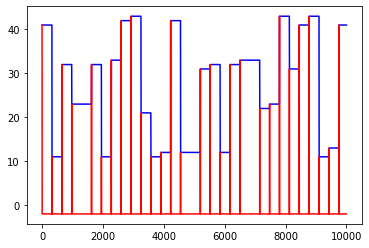

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(Events[:10000],'b-')
plt.plot(EventsProcessed[:10000],'r-')
plt.show()

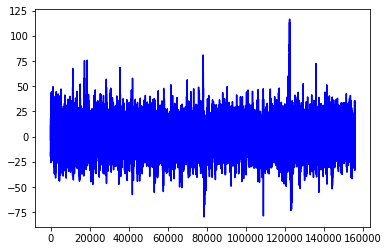

In [22]:
Signal = df['Oz'].values.tolist()
plt.plot(Signal,'b-')

In [23]:
df['event'] = EventsProcessed
df.iloc[170:180]

,time,condition,class,event,epoch,Fp1,F3,F7,FT9,FC5,FC1,C3,T7,TP9,CP5,CP1,Pz,P3,P7,O1,Oz,O2,P4,P8,TP10,CP6,CP2,Cz,C4,T8,FT10,FC6,FC2,F4,F8,Fp2,AF7,AF3,AFz,F1,F5,FT7,FC3,FCz,C1,C5,TP7,CP3,P1,P5,PO7,PO3,POz,PO4,PO8,P6,P2,CPz,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
170,180,Oreja,41,-2.0,1,39.782488,0.160368,-16.063542,-20.891446,-4.028496,-0.410508,-0.595094,-14.443433,-14.845426,-3.012180,-2.323188,-2.432188,-6.822639,-2.100402,-6.032140,-5.165440,-7.397210,-10.940326,-5.893935,-27.587986,-5.871724,-2.592379,1.653004,-4.696544,-29.936435,-30.647686,-4.943434,3.112141,0.615362,-9.145652,-48.351192,-8.303445,-1.643084,-8.231504,-1.721328,-10.410886,-21.343224,0.311721,-1.514386,-0.582923,-5.107318,-11.393163,-5.038634,-5.078078,-5.069253,-6.633265,-10.340281,-9.268217,-8.091157,-6.635842,-10.019554,-5.182021,-2.219660,-6.147612,-19.571488,-4.168682,-0.570743,0.026523,-26.933436,-9.333406,0.419245,-2.537101,-30.072873
171,184,Oreja,41,-2.0,1,28.228290,-1.180011,-19.144749,-16.389337,-1.028978,-0.087454,3.422986,-0.491259,-15.812993,1.272626,2.791575,2.629573,-3.000651,-2.058505,0.608127,-0.464595,-1.356246,-4.645268,-1.398685,-24.652073,2.257226,3.779903,5.226396,2.907345,-38.312838,-33.582031,-0.482870,6.152039,2.687338,-14.693821,-56.273324,-18.172498,-4.951571,-15.834058,-0.726548,-10.243439,-18.062134,3.295828,3.808298,3.751679,-1.587387,-3.881471,-0.711476,0.122785,-1.474949,0.600684,-2.280907,-3.126896,-3.418962,-1.858397,-3.797951,-0.021894,3.062828,2.112254,-18.761219,3.151426,4.672064,7.587173,-25.744718,-13.699816,1.702206,-7.055021,-24.465261
172,188,Oreja,41,-2.0,1,23.729984,-0.461479,-17.703144,-30.624229,-1.522959,-0.445813,0.332219,-11.945068,-32.720048,-0.871740,0.734453,1.145923,-4.310785,1.320353,-3.008990,-7.623180,-8.256926,-8.192597,-5.530643,-27.519919,-2.492274,0.078591,4.813193,-1.686058,-32.297675,-41.358009,-3.131459,4.515413,-0.417869,-19.304547,-59.760777,-26.368576,-6.684167,-17.479880,0.366602,-5.346970,-25.132566,1.973824,2.462550,1.839738,-5.037866,-10.397531,-1.659404,-0.931324,-3.031540,-3.032138,-5.134706,-6.172081,-6.672547,-5.827736,-7.934103,-2.519805,0.485435,-2.685516,-18.517226,-1.456589,2.631690,3.435698,-24.898857,-18.398479,0.247759,-4.319487,-39.823535
173,192,Oreja,41,-2.0,1,29.344022,-3.051565,-27.721608,-42.432832,-9.839956,-2.635344,-5.138355,-33.568872,-15.320170,-9.567181,-2.409354,-1.840103,-7.146257,-10.448791,-4.943949,-12.163429,-14.618518,-13.476381,-10.584654,-30.757429,-7.963959,-2.287647,3.917750,-9.578781,-36.253103,-46.312156,-7.639898,1.407671,-1.271384,-22.229903,-62.146811,-27.472832,-7.649899,-13.647811,-2.211739,-10.848602,-38.204880,-2.563731,1.346032,-1.107215,-15.008271,-30.727617,-6.735119,-3.146299,-6.763585,-4.837305,-7.893734,-8.387100,-11.013787,-10.340523,-10.977328,-5.869064,-1.690492,-8.058324,-18.869956,-8.233387,-0.588549,-3.374666,-38.726606,-21.506798,-0.497887,-5.743140,-60.003120
174,196,Oreja,41,-2.0,1,31.138771,0.034432,-32.610610,-44.504702,-6.680406,0.681419,-0.373158,-30.359989,-30.131035,-3.038727,-0.028656,-1.185357,-2.121159,-2.251127,-1.928136,-15.774237,-18.049949,-14.583800,-12.379764,-32.673048,-8.672289,-0.318065,3.816468,-12.188151,-26.567558,-48.854311,-8.908694,1.535874,-6.553403,-22.414342,-65.663317,-25.566014,-3.546136,-9.629988,1.266718,-7.458823,-39.988533,1.918671,1.970206,1.974644,-8.591898,-11.419883,-1.694709,-1.721394,0.835961,-2.920732,-4.213122,-8.967506,-13.356731,-13.428499,-15.520341,-6.065610,-0.584139,-8.464227,-17.924695,-11.934863,-0.483315,-4.768072,-57.576969,-21.787527,-6.258468,-5.933065,-56.679682
175,200,Oreja,41,-2.0,1,27.433580,-4.502285,-18.500338,-35.603860,-12.075265,-0.559397,-1.916716,-18.878449,-31.612910,-2.315252,0.052046,1.724565,-0.416037,-1.623727,-0.400069,-12.392484,-13.850603,-12.195844,-7.914844,-22.254828,-10.874095,0.865781,4.914311,-12.314015,-13.657005,-50.182996,-10.905032,2.526296,-5.017447,-33.007861,-65.809380,-19.623026,-6.515598,-14.445234,-4.552734,-15.273865,-24.582652,-4.450500,4.0879

In [24]:
classes_names = list(df['condition'].unique())
print(classes_names)

['Oreja', 'Manzana', 'Silla', 'Oveja', 'Violin', 'Ojo', 'Mano', 'Mariposa', 'Zanahoria', 'Coche', 'Pollo', 'Rosa']


    Using multitaper spectrum estimation with 7 DPSS windows


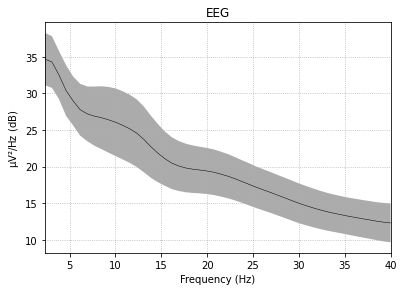

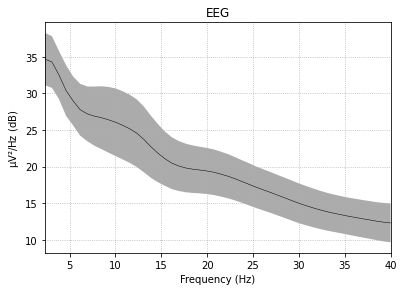

In [ ]:
epochs.plot_psd(fmin=2., fmax=40., average=True, spatial_colors=False)

    Using multitaper spectrum estimation with 7 DPSS windows


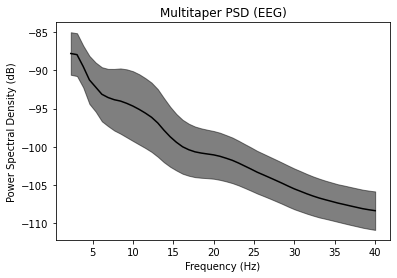

In [ ]:
f, ax = plt.subplots()
psds, freqs = psd_multitaper(epochs, fmin=2, fmax=40, n_jobs=1)
psds = 10. * np.log10(psds)
psds_mean = psds.mean(0).mean(0)
psds_std = psds.mean(0).std(0)

ax.plot(freqs, psds_mean, color='k')
ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='k', alpha=.5)
ax.set(title='Multitaper PSD (EEG)', xlabel='Frequency (Hz)',
       ylabel='Power Spectral Density (dB)')
plt.show()

Effective window size : 1.024 (s)
Effective window size : 1.024 (s)


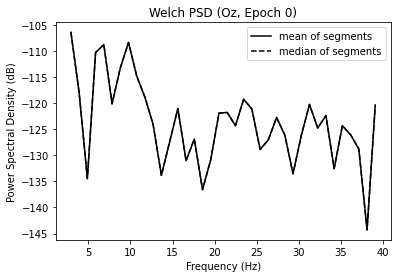

In [ ]:
kwargs = dict(fmin=2, fmax=40, n_jobs=1)
psds_welch_mean, freqs_mean = psd_welch(epochs, average='mean', **kwargs)
psds_welch_median, freqs_median = psd_welch(epochs, average='median', **kwargs)

# Convert power to dB scale.
psds_welch_mean = 10 * np.log10(psds_welch_mean)
psds_welch_median = 10 * np.log10(psds_welch_median)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = 'Oz'
ch_idx = epochs.info['ch_names'].index(ch_name)
epo_idx = 0

_, ax = plt.subplots()
ax.plot(freqs_mean, psds_welch_mean[epo_idx, ch_idx, :], color='k',
        ls='-', label='mean of segments')
ax.plot(freqs_median, psds_welch_median[epo_idx, ch_idx, :], color='k',
        ls='--', label='median of segments')

ax.set(title='Welch PSD ({}, Epoch {})'.format(ch_name, epo_idx),
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='upper right')
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows


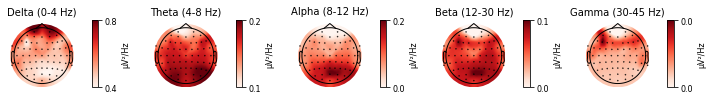

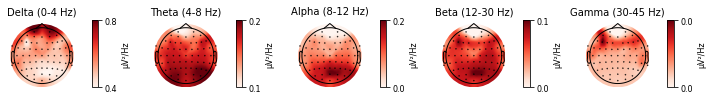

In [ ]:
epochs.plot_psd_topomap(ch_type='eeg', normalize=True)

In [ ]:
# define frequencies of interest (log-spaced)
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)

Applying baseline correction (mode: logratio)


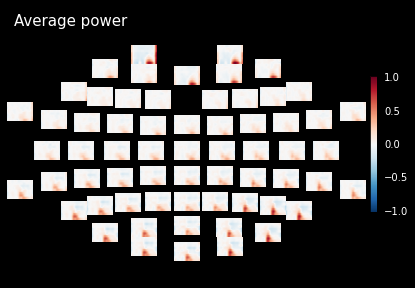

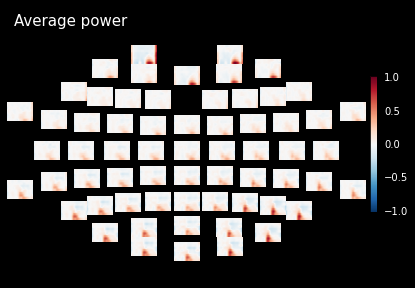

In [ ]:
power.plot_topo(baseline=baseline, mode='logratio', title='Average power')

Applying baseline correction (mode: logratio)


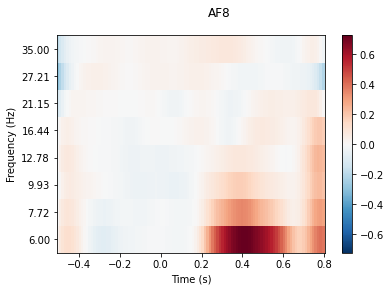

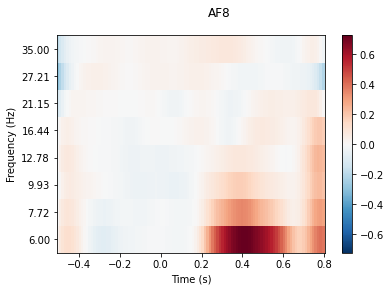

In [ ]:
power.plot([62], baseline=baseline, mode='logratio', title=power.ch_names[62])

Applying baseline correction (mode: logratio)


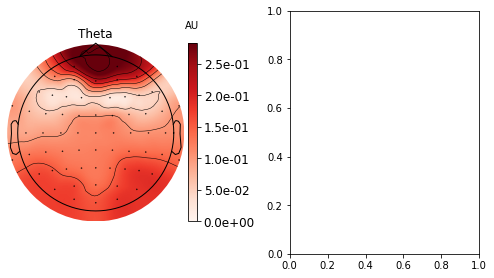

Applying baseline correction (mode: logratio)


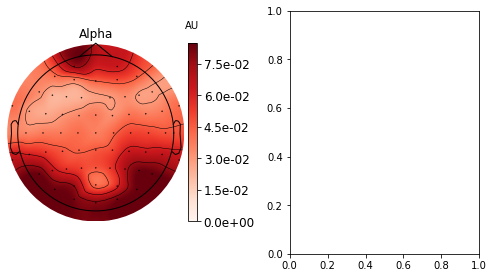

Applying baseline correction (mode: logratio)


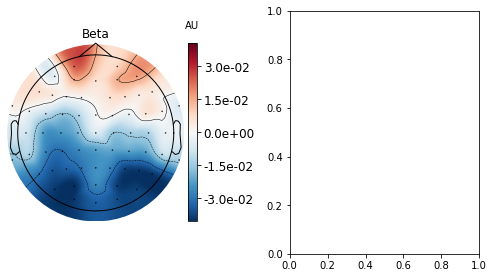

Applying baseline correction (mode: logratio)


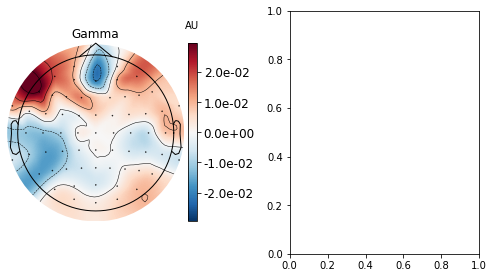

In [ ]:
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]


for band, fmin, fmax in iter_freqs:
  fig, axis = plt.subplots(1, 2, figsize=(7, 4))
  power.plot_topomap(ch_type='eeg', tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax,
                   baseline=baseline, mode='logratio', axes=axis[0],
                   title=band, show=False)
  mne.viz.tight_layout()
  plt.show()

In [ ]:
iter_freqs

[('Theta', 4, 7), ('Alpha', 8, 12), ('Beta', 13, 25), ('Gamma', 30, 45)]

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


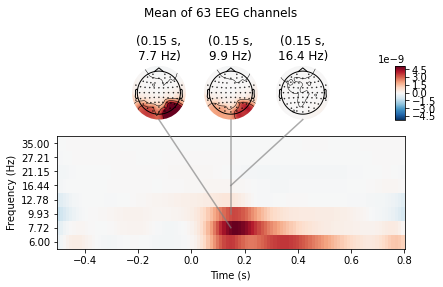

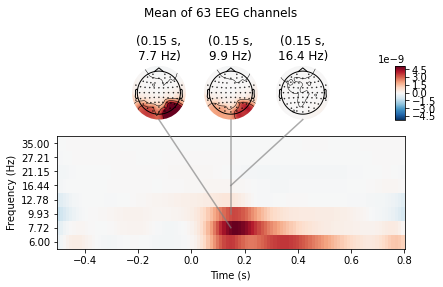

In [ ]:
power.plot_joint(baseline=baseline, mode='mean', tmin=tmin, tmax=tmax,
                 timefreqs=[(.15, 8), (.15, 10), (.15, 18)])

Computing rank from data with rank=None
    Using tolerance 3.6e+02 (2.2e-16 eps * 63 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 63 data channels with 0 projectors
Reducing data rank from 63 -> 63
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.2e+02 (2.2e-16 eps * 63 dim * 2.3e+16  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 63 data channels with 0 projectors
Reducing data rank from 63 -> 63
Estimating covariance using EMPIRICAL
Done.


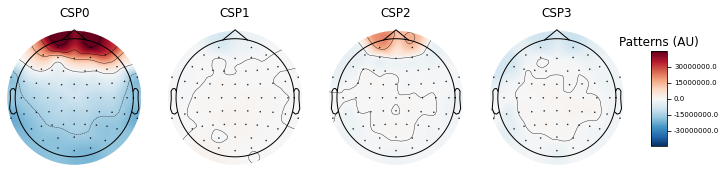

(600, 4)


In [ ]:
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

Xp, yp, zp = getEEGXY(df=df_per, channels=channels, columnClass='class', ColumnEpoch='epoch')

csp.fit(Xp,yp)
Xc = csp.transform(Xp)
csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print(Xc.shape)

Computing rank from data with rank=None
    Using tolerance 90 (2.2e-16 eps * 63 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 63 data channels with 0 projectors
Reducing data rank from 63 -> 63
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 93 (2.2e-16 eps * 63 dim * 6.7e+15  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 63 data channels with 0 projectors
Reducing data rank from 63 -> 63
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 91 (2.2e-16 eps * 63 dim * 6.5e+15  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 63 data channels with 0 projectors
Reducing data rank from 63 -> 63
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 90 (2.2e-16 eps * 63 dim * 6.4e+15  max singular value)
    Estimated rank (

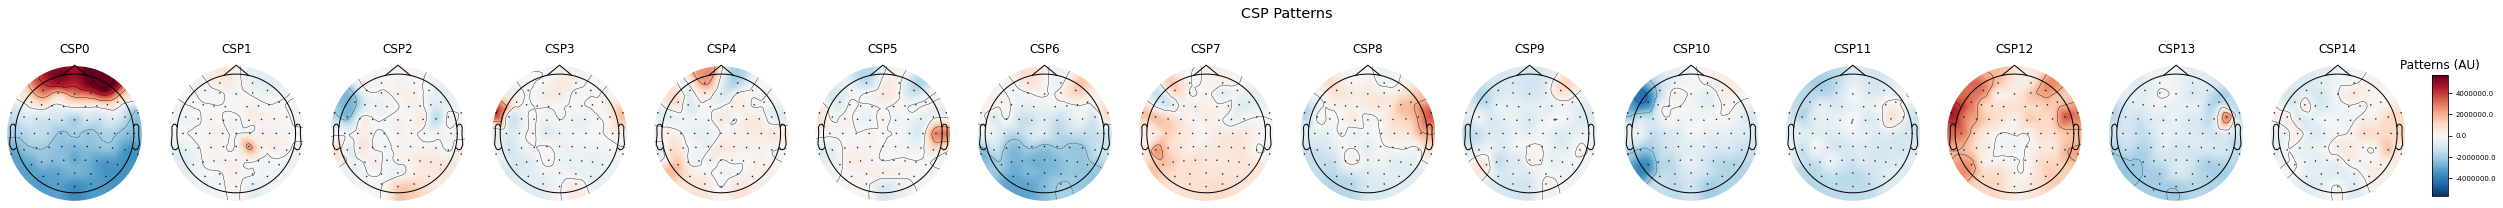

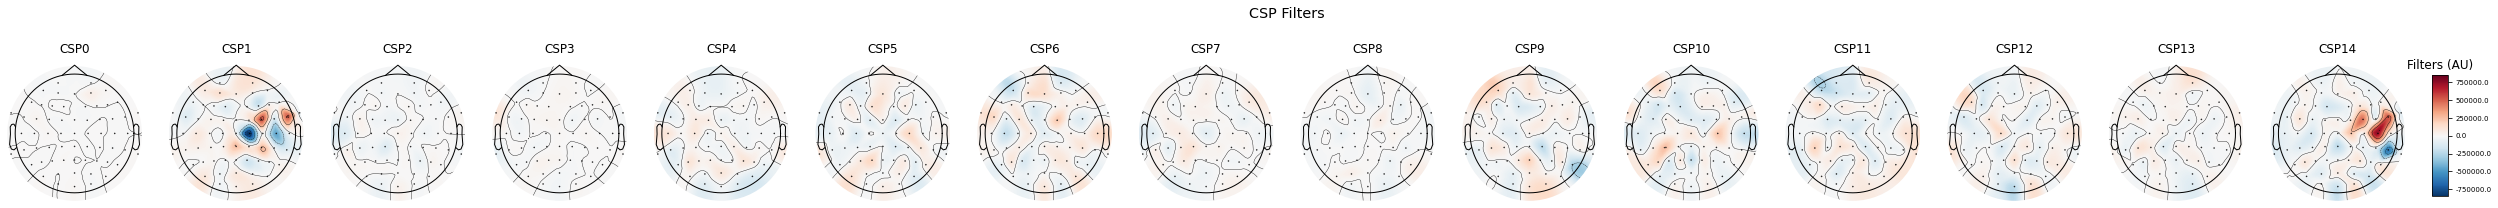

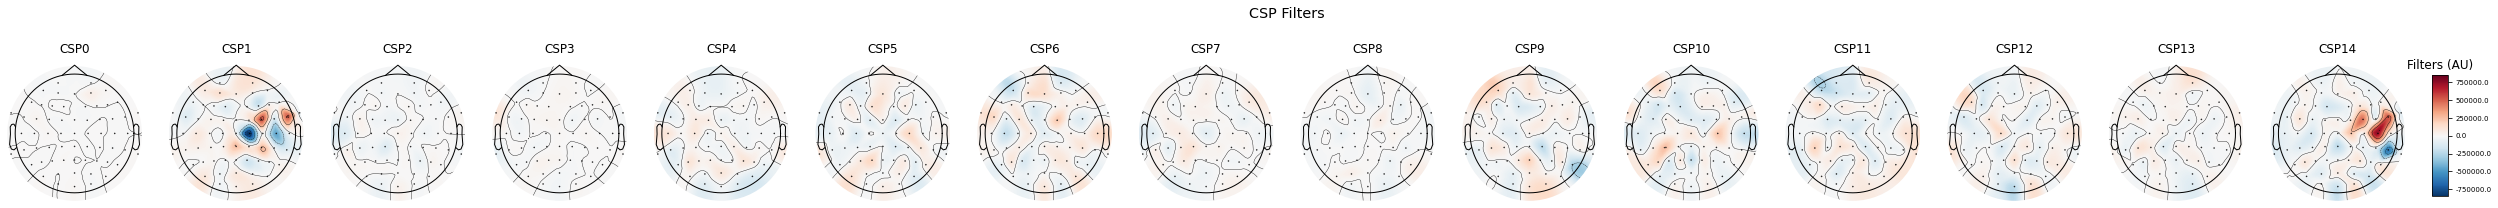

In [37]:
csp = CSP(n_components=15, reg=None, log=True, norm_trace=False)

X, y, z = getEEGXY(df=df, channels=channels, columnClass='class', ColumnEpoch='epoch')

csp.fit(X,y)
#Xc = csp.transform(X)
csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5, title= 'CSP Patterns')
csp.plot_filters(epochs.info, ch_type='eeg', units='Filters (AU)', size=1.5, title= 'CSP Filters')

In [31]:
X, y, z = getEEGXY(df=df, channels=channels, columnClass='class', ColumnEpoch='epoch')

classes = list(df['class'].unique())
y = label_binarize(y, classes=classes)
n_classes = y.shape[1]

classes_names = list(df['condition'].unique())

for i, c in zip (range(n_classes), classes_names):
  print(y[:,i].shape)
  csp.fit(X,y[:,i])
  Xc = csp.transform(X)
  csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5, title= 'CSP from '+c)
  print(Xc.shape)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# let's explore some frequency bands from perception
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

event_id= {'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43}

frequency_map = list()

for band, fmin, fmax in iter_freqs:
    # (re)load the data to save memory
    raw = mne.io.read_raw_brainvision(data_raw_file)
    raw.load_data()

    # bandpass filter
    raw.filter(fmin, fmax, n_jobs=1,  # use more jobs to speed up.
               l_trans_bandwidth=1,  # make sure filter params are the same
               h_trans_bandwidth=1)  # in each band and skip "auto" option.

    # epoch
    epochs_filter = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline,
                               preload=True).resample(250)# Resample of 1000 Hz to 250Hz
    # remove evoked response
    epochs_filter.subtract_evoked()

    # get analytic signal (envelope)
    epochs_filter.apply_hilbert(envelope=True)
    frequency_map.append(((band, fmin, fmax), epochs_filter.average()))
    del epochs_filter
del raw

Extracting parameters from /content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/subj01/ses01/per/PERIMG01_0002.vhdr...
Setting channel info structure...
Reading 0 ... 684959  =      0.000 ...   684.959 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 3301 samples (3.301 sec)

Not setting metadata
Not setting metadata
480 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 480 events and 1301 original time 

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Text(0.5, 0, 'Time [ms]')

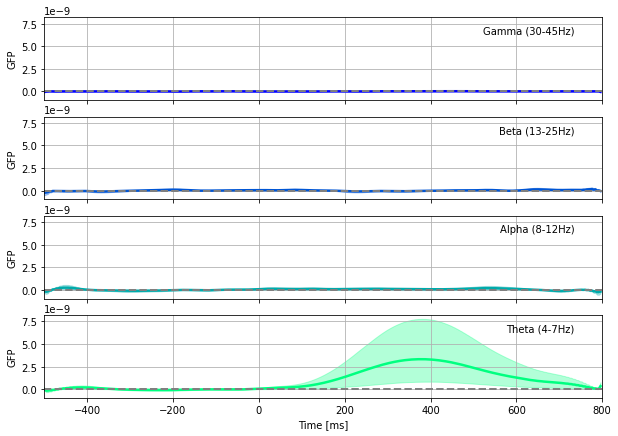

In [ ]:
# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-500, 800)

axes.ravel()[-1].set_xlabel('Time [ms]')

In [ ]:
# let's explore some frequency bands from descanso
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

event_id = 88

frequency_map = list()

for band, fmin, fmax in iter_freqs:
    # (re)load the data to save memory
    raw = mne.io.read_raw_brainvision(data_raw_file)
    raw.load_data()

    # bandpass filter
    raw.filter(fmin, fmax, n_jobs=1,  # use more jobs to speed up.
               l_trans_bandwidth=1,  # make sure filter params are the same
               h_trans_bandwidth=1)  # in each band and skip "auto" option.

    # epoch
    epochs_filter = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline,
                               preload=True).resample(250)# Resample of 1000 Hz to 250Hz
    # remove evoked response
    epochs_filter.subtract_evoked()

    # get analytic signal (envelope)
    epochs_filter.apply_hilbert(envelope=True)
    frequency_map.append(((band, fmin, fmax), epochs_filter.average()))
    del epochs_filter
del raw

Extracting parameters from /content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/subj01/ses01/per/PERIMG01_0002.vhdr...
Setting channel info structure...
Reading 0 ... 684959  =      0.000 ...   684.959 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 3301 samples (3.301 sec)

Not setting metadata
Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 120 events and 1301 original time 

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Text(0.5, 0, 'Time [ms]')

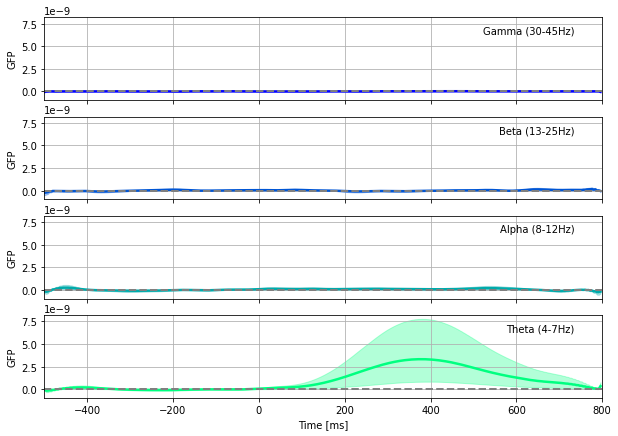

In [ ]:
# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-500, 800)

axes.ravel()[-1].set_xlabel('Time [ms]')

**BANDAS DE FRECUENCIA POR CLASE**

++++++++++++++++++++++++++++++++Manzana
Extracting parameters from /content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/subj01/ses01/per/PERIMG01_0002.vhdr...
Setting channel info structure...
Reading 0 ... 684959  =      0.000 ...   684.959 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 3301 samples (3.301 sec)

Not setting metadata
Not setting metadata
40 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data

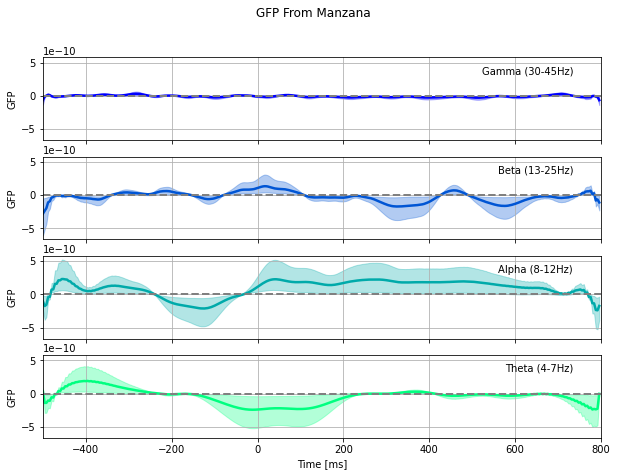

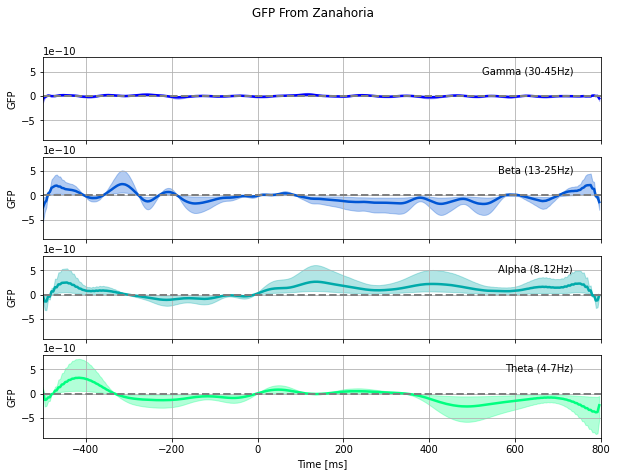

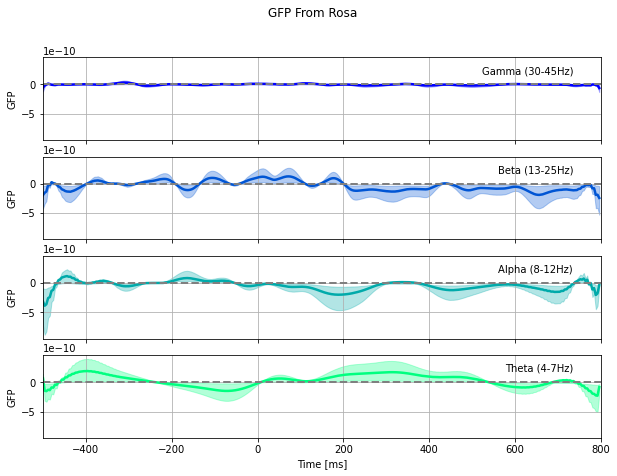

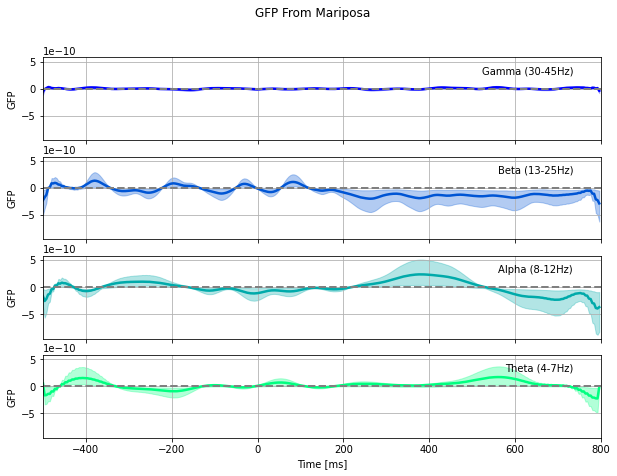

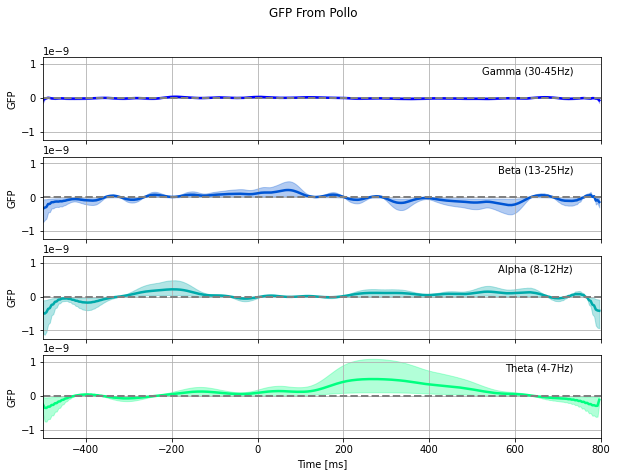

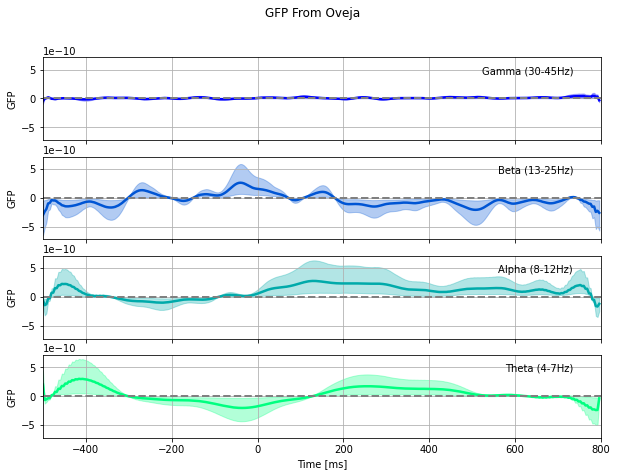

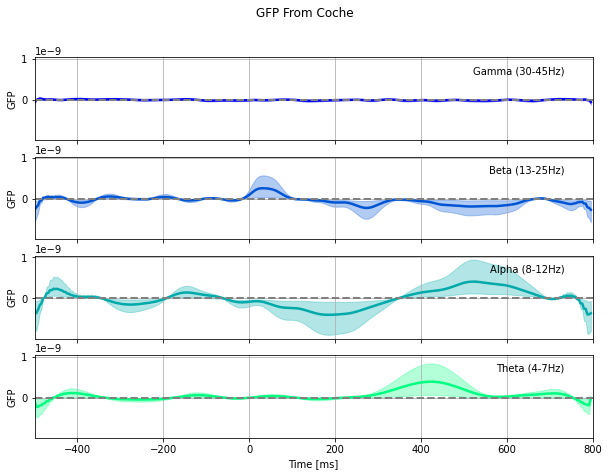

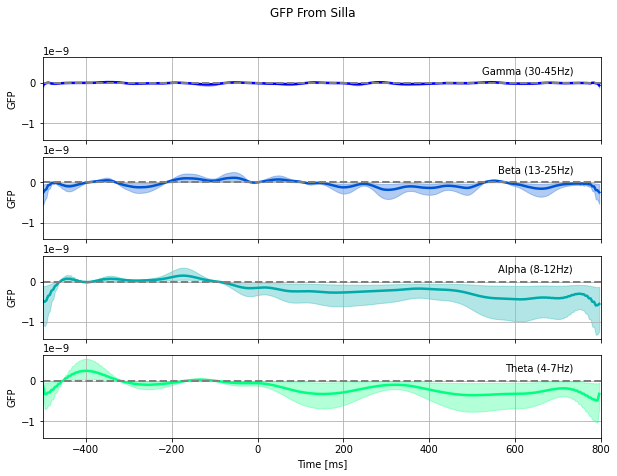

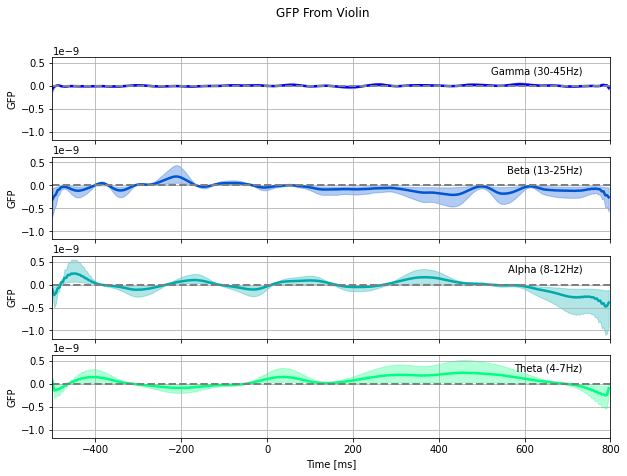

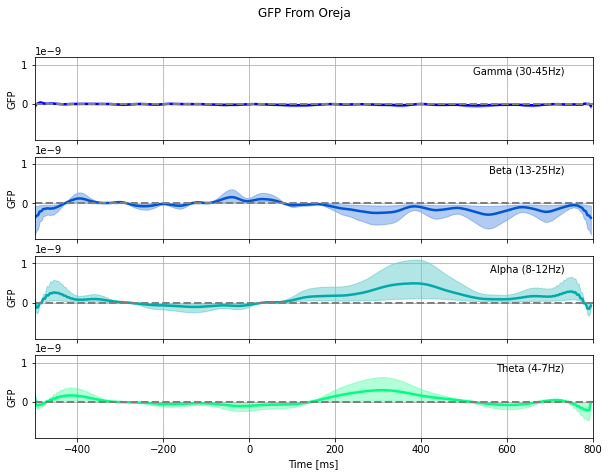

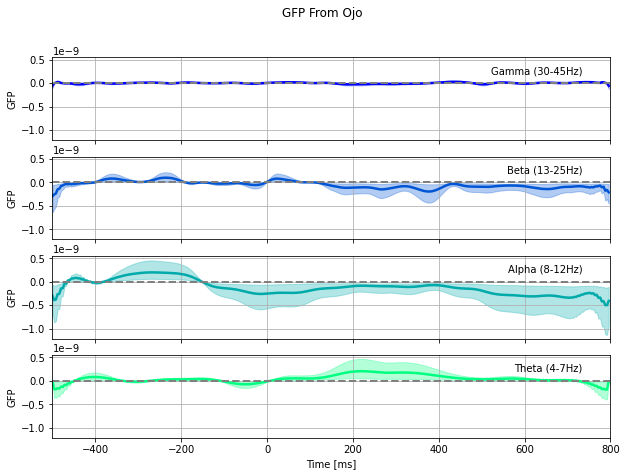

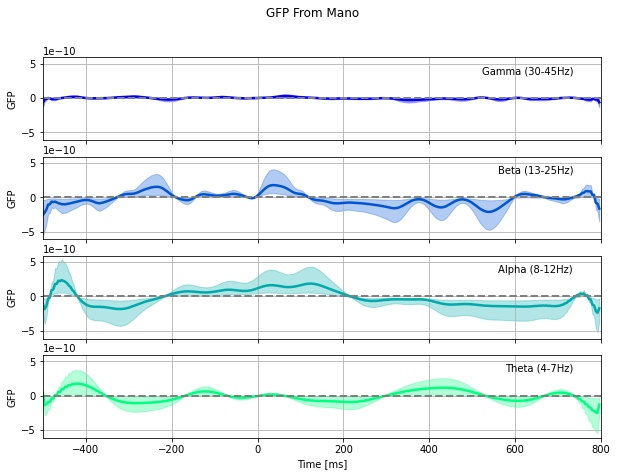

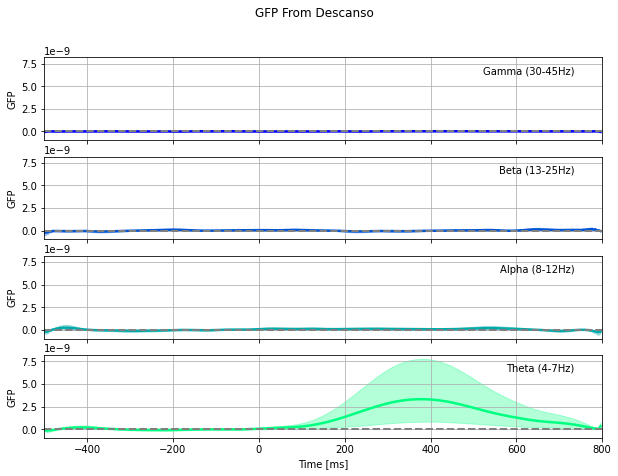

In [ ]:
# let's explore some frequency bands from descanso
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]
event_name= {'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43, 'Descanso': 88}
for name, event_id in zip(event_name.keys(), event_name.values()):
  print('++++++++++++++++++++++++++++++++'+name)
  frequency_map = list()
  
  for band, fmin, fmax in iter_freqs:
    
      # (re)load the data to save memory
      raw = mne.io.read_raw_brainvision(data_raw_file)
      raw.load_data()

      # bandpass filter
      raw.filter(fmin, fmax, n_jobs=1,  # use more jobs to speed up.
                 l_trans_bandwidth=1,  # make sure filter params are the same
                 h_trans_bandwidth=1)  # in each band and skip "auto" option.

      # epoch
      epochs_filter = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline,
                               preload=True).resample(250)# Resample of 1000 Hz to 250Hz
      # remove evoked response
      epochs_filter.subtract_evoked()

      # get analytic signal (envelope)
      epochs_filter.apply_hilbert(envelope=True)
      frequency_map.append(((band, fmin, fmax), epochs_filter.average()))
      del epochs_filter
  del raw

  # Plot
  fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
  fig.suptitle('GFP From '+ name)
  colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
  for ((freq_name, fmin, fmax), average), color, ax in zip(
          frequency_map, colors, axes.ravel()[::-1]):
      times = average.times * 1e3
      gfp = np.sum(average.data ** 2, axis=0)
      gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
      ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
      ax.axhline(0, linestyle='--', color='grey', linewidth=2)
      ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
      ci_low = rescale(ci_low, average.times, baseline=(None, 0))
      ci_up = rescale(ci_up, average.times, baseline=(None, 0))
      ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
      ax.grid(True)
      ax.set_ylabel('GFP')
      ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                  xy=(0.95, 0.8),
                  horizontalalignment='right',
                  xycoords='axes fraction')
      ax.set_xlim(-500, 800)

  axes.ravel()[-1].set_xlabel('Time [ms]')

In [ ]:
# Define channels and time interval of interest to visualize
channelsOfInterest = ['Pz','P3','P7','O1','Oz','O2','P4','P8','P1','P5','PO7','PO3','POz','PO4','PO8','P6','P2','C3']
init = round(0.8*len(df)) # from 0% of signal length
end = round(0.85*len(df)) # to 100% of signal length

In [ ]:
plotMultiChannelSignal(df=df[channelsOfInterest], events=df['event'].values.tolist(), 
                       sfreq=Fs, init=init, end=end, title='Multichannel Biosignal', 
                       ylabel='Amplitude', xlabel='Time (s)')

Output hidden; open in https://colab.research.google.com to view.